In [106]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, TFRobertaModel


In [107]:
# Set up the TPU or GPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU:', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Running on GPU:', strategy.num_replicas_in_sync)

Running on GPU: 1


In [108]:
# Constants
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

print(BATCH_SIZE)

8


In [134]:
# Read the dataset
df = pd.read_csv('/kaggle/input/livedx-t-ai-1-500-more/livedx_T_AI_1 500 more.csv')
final_df = pd.read_csv('/kaggle/input/final-output-file/Final output_file.csv')  

In [135]:
columns = df.columns.tolist()
generated_text = final_df[['generated_text', 'Task1', 'Task2', 'Task3', 'Task4',
       'Task5', 'Task6', 'Task7', 'Task8', 'Task9', 'Task10', 'Task11',
       'Task12', 'Task_P']]
generated_text.columns = ['Text', 'Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6', 'Task7', 'Task8', 'Task9', 'Task10', 'Task11', 'Task12', 'Task13']
generated_text = generated_text.dropna()
print(generated_text.shape)

(814, 14)


In [136]:
df.head()

,Text,Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9,Task10,Task11,Task12,Task13,Task15
0,i didn't spend all my money buying squishmallo...,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,It was a busy day at work and as I was quite b...,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,Ive been reading a book that helped answer a l...,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,I worked out. tough. worked out. working out i...,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,"The situation was not that easy to handle, but...",0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [137]:
# Split the dataset into X_data (text) and task labels (Task1 to Task14)
X_data = df['Text'].values
task_labels = df.iloc[:, 1:14].values.astype('int32')
presence_labels = df['Task15'].values.astype('int32')

In [113]:
X_data_gen = generated_text['Text'].values
task_labels_gen = generated_text.iloc[:, 1:13].values.astype('int32')
presence_labels_gen = generated_text['Task13'].values.astype('int32')

In [139]:
task_labels_sum

array([333, 195,  61, 130,  38,  66,  55,  32,  24, 298,  66,  35,  26,
        86])

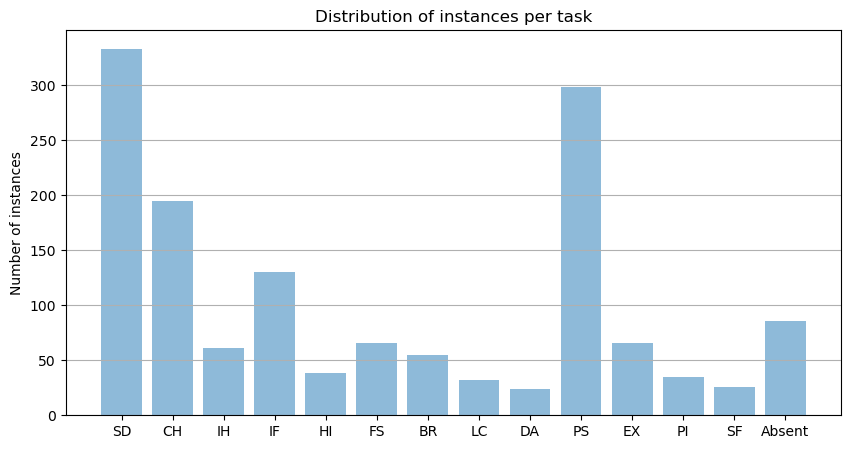

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'task_labels' is a NumPy ndarray containing the task labels
task_labels_sum = np.sum(df.iloc[:, 1:15].values.astype('int32'), axis=0)
task_labels_sum[13] = df.shape[0] - task_labels_sum[13]
task_names = ["SD", "CH", "IH", "IF", "HI", "FS", "BR", "LC", "DA","PS" ,"EX", "PI", "SF", "Absent"]

plt.figure(figsize=(10, 5))
plt.bar(task_names, task_labels_sum, align='center', alpha=0.5)
plt.ylabel('Number of instances')
plt.title('Distribution of instances per task')
plt.gca().yaxis.grid(True)
plt.show()


In [115]:
# Split the dataset into train and test sets
X_train, X_test, y_train_task, y_test_task, y_train_presence, y_test_presence = train_test_split(
    X_data, task_labels, presence_labels, test_size=0.3, shuffle=True, random_state=777)


X_train_gen, X_test_gen, y_train_task_gen, y_test_task_gen, y_train_presence_gen, y_test_presence_gen = train_test_split(
    X_data_gen, task_labels_gen, presence_labels_gen, test_size=0.2, shuffle=True, random_state=777)

In [116]:
def balanced_df(df,label):
    positive_samples = df[df[label] == 1]
    negative_samples = df[df[label] == 0]
    bal = 0
    if len(positive_samples) ==0 or len(negative_samples)==0:
        upsampled_positive_samples = positive_samples
        upsampled_negative_samples = negative_samples
    elif positive_samples.shape[0]>negative_samples.shape[0]:
        upsampled_positive_samples = positive_samples
        upsampled_negative_samples = negative_samples.sample(n=int(len(positive_samples)/4), replace=True)
    else:
        upsampled_positive_samples = positive_samples.sample(n=int(len(negative_samples)/4), replace=True)
        upsampled_negative_samples = negative_samples
    balanced_data = pd.concat([upsampled_positive_samples, upsampled_negative_samples])
    balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
    return balanced_data
def balanced_dataset(X_data, task_labels, presence_labels):
    #X_data, task_labels, presence_labels
    X_data = np.reshape(X_data, (X_data.shape[0], 1))
    presence_labels = np.reshape(presence_labels, (presence_labels.shape[0], 1)) 
    print(X_data.shape, task_labels.shape, presence_labels.shape)
    merge_df = np.hstack((X_data, task_labels, presence_labels))
    merge_df = pd.DataFrame(data = merge_df, columns = ["Text", "SDPS", "CH", "IH", "IF", "HI", "FS", "BR", "LC", "DA", "EX", "PI", "SF", "Present"])
    balanced_data = merge_df
    for i in ["Present", "SDPS", "CH", "IH", "IF", "HI", "FS", "BR", "LC", "DA", "EX", "PI", "SF"]:
        balanced_data = balanced_df(balanced_data,i)
    X_data = balanced_data['Text'].values
    task_labels = balanced_data[["SDPS", "CH", "IH", "IF", "HI", "FS", "BR", "LC", "DA", "EX", "PI", "SF"]].values
    presence_labels = balanced_data['Present'].values
    return (X_data, np.asarray(task_labels) , np.asarray(presence_labels))

In [117]:
X_train, y_train_task, y_train_presence = balanced_dataset(X_train, y_train_task, y_train_presence)
print(X_train.shape, y_train_task.shape, y_train_presence.shape)
X_test, y_test_task, y_test_presence = balanced_dataset(X_test, y_test_task, y_test_presence)
print(X_test.shape, y_test_task.shape, y_test_presence.shape)

(1048, 1) (1048, 12) (1048, 1)
(6851,) (6851, 12) (6851,)
(450, 1) (450, 12) (450, 1)
(3076,) (3076, 12) (3076,)


In [118]:
np.unique(y_test_task_gen)

array([0, 1], dtype=int32)

In [119]:
print(X_train_gen.shape, y_train_task_gen.shape, y_train_presence_gen.shape)
print(X_test_gen.shape, y_test_task_gen.shape, y_test_presence_gen.shape)

(651,) (651, 12) (651,)
(163,) (163, 12) (163,)


In [120]:

X_train_gen, y_train_task_gen, y_train_presence_gen = balanced_dataset(X_train_gen, y_train_task_gen, y_train_presence_gen)
print(X_train_gen.shape, y_train_task_gen.shape, y_train_presence_gen.shape)
X_test_gen, y_test_task_gen, y_test_presence_gen = balanced_dataset(X_test_gen, y_test_task_gen, y_test_presence_gen)
print(X_test_gen.shape, y_test_task_gen.shape, y_test_presence_gen.shape)

(651, 1) (651, 12) (651, 1)
(2613,) (2613, 12) (2613,)
(163, 1) (163, 12) (163, 1)
(352,) (352, 12) (352,)


In [121]:
# Initialize the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [122]:
# Encode the text data using the tokenizer
def roberta_encode(texts, tokenizer):
    input_ids = np.ones((len(texts), MAX_LEN), dtype='int32')
    attention_mask = np.zeros((len(texts), MAX_LEN), dtype='int32')

    for i, text in enumerate(texts):
        tokens = tokenizer.tokenize(text)
        tokens = tokens[:MAX_LEN-2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        input_ids[i, :len(tokens)] = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask[i, :len(tokens)] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask
    }

In [123]:
# Encode the train and test data
X_train_encoded = roberta_encode(X_train, tokenizer)
X_test_encoded = roberta_encode(X_test, tokenizer)
X_train_encoded_gen = roberta_encode(X_train_gen, tokenizer)
X_test_encoded_gen = roberta_encode(X_test_gen, tokenizer)

In [124]:
# Define the Multitask Cascaded Roberta model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_model():
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')

        roberta = TFRobertaModel.from_pretrained(MODEL_NAME)
        roberta.resize_token_embeddings(len(tokenizer))

        sequence_output = roberta(input_word_ids, attention_mask=input_mask)[0]
        cls_token = sequence_output[:, 0, :]

        presence_output = tf.keras.layers.Dense(1, activation='sigmoid', name='presence_output')(cls_token)
        task_output = tf.keras.layers.Dense(12, activation='sigmoid', name='task_output')(cls_token)

        task_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        presence_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        task_metrics = [tf.keras.metrics.BinaryAccuracy(name='task{}_accuracy'.format(i+1)) for i in range(13)]
        presence_metrics = tf.keras.metrics.BinaryAccuracy(name='presence_accuracy')

        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=[task_output, presence_output])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss={'task_output': task_loss, 'presence_output': presence_loss},
                      metrics={'task_output': task_metrics, 'presence_output': presence_metrics})

    return model


    
def build_model1():
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')

    roberta = TFRobertaModel.from_pretrained(MODEL_NAME)
    roberta.resize_token_embeddings(len(tokenizer))

    sequence_output = roberta(input_word_ids, attention_mask=input_mask)[0]
    cls_token = sequence_output[:, 0, :]

    presence_output = tf.keras.layers.Dense(1, activation='sigmoid', name='presence_output', kernel_regularizer='l1')(cls_token)
    task1_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output1', kernel_regularizer='l1')(cls_token)
    task2_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output2', kernel_regularizer='l1')(cls_token)
    task3_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output3', kernel_regularizer='l1')(cls_token)
    task4_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output4', kernel_regularizer='l1')(cls_token)
    task5_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output5', kernel_regularizer='l1')(cls_token)
    task6_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output6', kernel_regularizer='l1')(cls_token)
    task7_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output7', kernel_regularizer='l1')(cls_token)
    task8_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output8', kernel_regularizer='l1')(cls_token)
    task9_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output9', kernel_regularizer='l1')(cls_token)
    task10_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output10', kernel_regularizer='l1')(cls_token)
    task11_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output11', kernel_regularizer='l1')(cls_token)
    task12_output = tf.keras.layers.Dense(1, activation='sigmoid', name='task_output12', kernel_regularizer='l1')(cls_token)


    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=[task1_output,task2_output,task3_output,task4_output,task5_output,task6_output, task7_output,task8_output,task9_output,task10_output,task11_output,task12_output,presence_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['acc',f1_m,precision_m, recall_m])

    return model

In [125]:
# Build and compile the model
model = build_model1()
modelD3  = build_model1()
#model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [126]:
np.unique(y_train_task)

array([0, 1], dtype=object)

In [127]:
y_train_task = y_train_task.astype(int)
y_train_presence = y_train_presence.astype(int)
y_test_task = y_test_task.astype(int)
y_test_presence = y_test_presence.astype(int)

y_train_task_gen = y_train_task_gen.astype(int)
y_train_presence_gen = y_train_presence_gen.astype(int)
y_test_task_gen = y_test_task_gen.astype(int)
y_test_presence_gen = y_test_presence_gen.astype(int)

In [128]:
# Train D2 the model
history = model.fit(
    x=X_train_encoded,
    y={'task_output1': y_train_task[:,0],'task_output2': y_train_task[:,1],'task_output3': y_train_task[:,2],'task_output4': y_train_task[:,3],
       'task_output5': y_train_task[:,4],'task_output6': y_train_task[:,5],'task_output7': y_train_task[:,6],'task_output8': y_train_task[:,7],
       'task_output9': y_train_task[:,8],'task_output10': y_train_task[:,9],'task_output11': y_train_task[:,10],'task_output12': y_train_task[:,11],
       'presence_output': y_train_presence},
    validation_split=0.2, epochs=2, batch_size=16, verbose = 1
)



Epoch 1/2
343/343 [==============================] - 368s 914ms/step - loss: 6.4730 - task_output1_loss: 0.2160 - task_output2_loss: 0.1946 - task_output3_loss: 0.1562 - task_output4_loss: 0.1699 - task_output5_loss: 0.1646 - task_output6_loss: 0.1858 - task_output7_loss: 0.1475 - task_output8_loss: 0.1499 - task_output9_loss: 0.1237 - task_output10_loss: 0.1648 - task_output11_loss: 0.1405 - task_output12_loss: 0.1213 - presence_output_loss: 0.1407 - task_output1_acc: 0.9228 - task_output1_f1_m: 0.2920 - task_output1_precision_m: 0.3471 - task_output1_recall_m: 0.2828 - task_output2_acc: 0.9358 - task_output2_f1_m: 0.6724 - task_output2_precision_m: 0.7424 - task_output2_recall_m: 0.6479 - task_output3_acc: 0.9526 - task_output3_f1_m: 0.5759 - task_output3_precision_m: 0.6247 - task_output3_recall_m: 0.5557 - task_output4_acc: 0.9422 - task_output4_f1_m: 0.7111 - task_output4_precision_m: 0.7587 - task_output4_recall_m: 0.6905 - task_output5_acc: 0.9281 - task_output5_f1_m: 0.7838 - t

In [129]:
# Evaluate D2 model on D2 HLIA
test_scores = model.evaluate(
    x=X_test_encoded,
    y={'task_output1': y_test_task[:,0],'task_output2': y_test_task[:,1],'task_output3': y_test_task[:,2],'task_output4': y_test_task[:,3],
       'task_output5': y_test_task[:,4],'task_output6': y_test_task[:,5],'task_output7': y_test_task[:,6],'task_output8': y_test_task[:,7],
       'task_output9': y_test_task[:,8],'task_output10': y_test_task[:,9],'task_output11': y_test_task[:,10],'task_output12': y_test_task[:,11],
       'presence_output': y_test_presence},
    batch_size=16,
    verbose=1
)



193/193 [==============================] - 55s 286ms/step - loss: 13.5882 - task_output1_loss: 0.4158 - task_output2_loss: 0.5049 - task_output3_loss: 0.5176 - task_output4_loss: 0.3305 - task_output5_loss: 1.1121 - task_output6_loss: 0.5253 - task_output7_loss: 0.3388 - task_output8_loss: 0.8815 - task_output9_loss: 0.5246 - task_output10_loss: 1.7204 - task_output11_loss: 0.8660 - task_output12_loss: 1.4538 - presence_output_loss: 0.1821 - task_output1_acc: 0.8833 - task_output1_f1_m: 0.0041 - task_output1_precision_m: 0.0104 - task_output1_recall_m: 0.0026 - task_output2_acc: 0.7802 - task_output2_f1_m: 0.1897 - task_output2_precision_m: 0.1840 - task_output2_recall_m: 0.2350 - task_output3_acc: 0.9002 - task_output3_f1_m: 0.6049 - task_output3_precision_m: 0.8117 - task_output3_recall_m: 0.5211 - task_output4_acc: 0.8599 - task_output4_f1_m: 0.2040 - task_output4_precision_m: 0.3117 - task_output4_recall_m: 0.1703 - task_output5_acc: 0.7341 - task_output5_f1_m: 0.0000e+00 - task_ou

In [130]:
# Evaluate D2 model on D3 HLIA
test_scores = model.evaluate(
    x=X_test_encoded_gen,
    y={'task_output1': y_test_task_gen[:,0],'task_output2': y_test_task_gen[:,1],'task_output3': y_test_task_gen[:,2],'task_output4': y_test_task_gen[:,3],
       'task_output5': y_test_task_gen[:,4],'task_output6': y_test_task_gen[:,5],'task_output7': y_test_task_gen[:,6],'task_output8': y_test_task_gen[:,7],
       'task_output9': y_test_task_gen[:,8],'task_output10': y_test_task_gen[:,9],'task_output11': y_test_task_gen[:,10],'task_output12': y_test_task_gen[:,11],
       'presence_output': y_test_presence_gen},
    batch_size=16,
    verbose=1
)



22/22 [==============================] - 6s 282ms/step - loss: 9.2566 - task_output1_loss: 0.4326 - task_output2_loss: 0.1126 - task_output3_loss: 0.1168 - task_output4_loss: 0.0367 - task_output5_loss: 0.3781 - task_output6_loss: 0.0187 - task_output7_loss: 0.0102 - task_output8_loss: 0.0305 - task_output9_loss: 0.0317 - task_output10_loss: 1.3985 - task_output11_loss: 1.3078 - task_output12_loss: 0.0268 - presence_output_loss: 1.1409 - task_output1_acc: 0.9062 - task_output1_f1_m: 0.2890 - task_output1_precision_m: 0.4091 - task_output1_recall_m: 0.2386 - task_output2_acc: 0.9801 - task_output2_f1_m: 0.0000e+00 - task_output2_precision_m: 0.0000e+00 - task_output2_recall_m: 0.0000e+00 - task_output3_acc: 0.9545 - task_output3_f1_m: 0.0000e+00 - task_output3_precision_m: 0.0000e+00 - task_output3_recall_m: 0.0000e+00 - task_output4_acc: 0.9943 - task_output4_f1_m: 0.0000e+00 - task_output4_precision_m: 0.0000e+00 - task_output4_recall_m: 0.0000e+00 - task_output5_acc: 0.8381 - task_ou

In [131]:
# Train D3 the model
history = modelD3.fit(
    x=X_train_encoded_gen,
    y={'task_output1': y_train_task_gen[:,0],'task_output2': y_train_task_gen[:,1],'task_output3': y_train_task_gen[:,2],'task_output4': y_train_task_gen[:,3],
       'task_output5': y_train_task_gen[:,4],'task_output6': y_train_task_gen[:,5],'task_output7': y_train_task_gen[:,6],'task_output8': y_train_task_gen[:,7],
       'task_output9': y_train_task_gen[:,8],'task_output10': y_train_task_gen[:,9],'task_output11': y_train_task_gen[:,10],'task_output12': y_train_task_gen[:,11],
       'presence_output': y_train_presence_gen},
    validation_split=0.2, epochs=2, batch_size=16, verbose = 1
)



Epoch 1/2
131/131 [==============================] - 179s 935ms/step - loss: 6.5603 - task_output1_loss: 0.2441 - task_output2_loss: 0.1458 - task_output3_loss: 0.0633 - task_output4_loss: 0.1086 - task_output5_loss: 0.1484 - task_output6_loss: 0.1584 - task_output7_loss: 0.0820 - task_output8_loss: 0.1314 - task_output9_loss: 0.1514 - task_output10_loss: 0.1983 - task_output11_loss: 0.2060 - task_output12_loss: 0.1490 - presence_output_loss: 0.3817 - task_output1_acc: 0.9158 - task_output1_f1_m: 0.4683 - task_output1_precision_m: 0.5464 - task_output1_recall_m: 0.4348 - task_output2_acc: 0.9488 - task_output2_f1_m: 0.5278 - task_output2_precision_m: 0.5265 - task_output2_recall_m: 0.5534 - task_output3_acc: 1.0000 - task_output3_f1_m: 0.0000e+00 - task_output3_precision_m: 0.0000e+00 - task_output3_recall_m: 0.0000e+00 - task_output4_acc: 0.9402 - task_output4_f1_m: 0.0000e+00 - task_output4_precision_m: 0.0000e+00 - task_output4_recall_m: 0.0000e+00 - task_output5_acc: 0.9641 - task_

In [132]:
# Evaluate D3 model on D3 HLIA
test_scores = modelD3.evaluate(
    x=X_test_encoded_gen,
    y={'task_output1': y_test_task_gen[:,0],'task_output2': y_test_task_gen[:,1],'task_output3': y_test_task_gen[:,2],'task_output4': y_test_task_gen[:,3],
       'task_output5': y_test_task_gen[:,4],'task_output6': y_test_task_gen[:,5],'task_output7': y_test_task_gen[:,6],'task_output8': y_test_task_gen[:,7],
       'task_output9': y_test_task_gen[:,8],'task_output10': y_test_task_gen[:,9],'task_output11': y_test_task_gen[:,10],'task_output12': y_test_task_gen[:,11],
       'presence_output': y_test_presence_gen},
    batch_size=16,
    verbose=1
)



22/22 [==============================] - 6s 284ms/step - loss: 10.3463 - task_output1_loss: 0.6330 - task_output2_loss: 0.0052 - task_output3_loss: 0.0031 - task_output4_loss: 0.0047 - task_output5_loss: 0.7006 - task_output6_loss: 0.0043 - task_output7_loss: 0.0025 - task_output8_loss: 0.0027 - task_output9_loss: 0.0025 - task_output10_loss: 1.5555 - task_output11_loss: 0.9380 - task_output12_loss: 0.0031 - presence_output_loss: 2.1926 - task_output1_acc: 0.8807 - task_output1_f1_m: 0.0000e+00 - task_output1_precision_m: 0.0000e+00 - task_output1_recall_m: 0.0000e+00 - task_output2_acc: 1.0000 - task_output2_f1_m: 0.0000e+00 - task_output2_precision_m: 0.0000e+00 - task_output2_recall_m: 0.0000e+00 - task_output3_acc: 1.0000 - task_output3_f1_m: 0.0000e+00 - task_output3_precision_m: 0.0000e+00 - task_output3_recall_m: 0.0000e+00 - task_output4_acc: 1.0000 - task_output4_f1_m: 0.0000e+00 - task_output4_precision_m: 0.0000e+00 - task_output4_recall_m: 0.0000e+00 - task_output5_acc: 0.8

In [133]:
# Evaluate D3 model on D2 HLIA
test_scores = modelD3.evaluate(
    x=X_test_encoded,
    y={'task_output1': y_test_task[:,0],'task_output2': y_test_task[:,1],'task_output3': y_test_task[:,2],'task_output4': y_test_task[:,3],
       'task_output5': y_test_task[:,4],'task_output6': y_test_task[:,5],'task_output7': y_test_task[:,6],'task_output8': y_test_task[:,7],
       'task_output9': y_test_task[:,8],'task_output10': y_test_task[:,9],'task_output11': y_test_task[:,10],'task_output12': y_test_task[:,11],
       'presence_output': y_test_presence},
    batch_size=16,
    verbose=1
)



193/193 [==============================] - 55s 282ms/step - loss: 17.9755 - task_output1_loss: 0.6580 - task_output2_loss: 0.6230 - task_output3_loss: 1.1613 - task_output4_loss: 0.7348 - task_output5_loss: 0.6143 - task_output6_loss: 0.4708 - task_output7_loss: 0.4636 - task_output8_loss: 0.8986 - task_output9_loss: 0.8049 - task_output10_loss: 1.6573 - task_output11_loss: 0.7606 - task_output12_loss: 1.1790 - presence_output_loss: 3.6508 - task_output1_acc: 0.8836 - task_output1_f1_m: 0.0000e+00 - task_output1_precision_m: 0.0000e+00 - task_output1_recall_m: 0.0000e+00 - task_output2_acc: 0.8804 - task_output2_f1_m: 0.0000e+00 - task_output2_precision_m: 0.0000e+00 - task_output2_recall_m: 0.0000e+00 - task_output3_acc: 0.8030 - task_output3_f1_m: 0.0000e+00 - task_output3_precision_m: 0.0000e+00 - task_output3_recall_m: 0.0000e+00 - task_output4_acc: 0.8586 - task_output4_f1_m: 0.0000e+00 - task_output4_precision_m: 0.0000e+00 - task_output4_recall_m: 0.0000e+00 - task_output5_acc: 

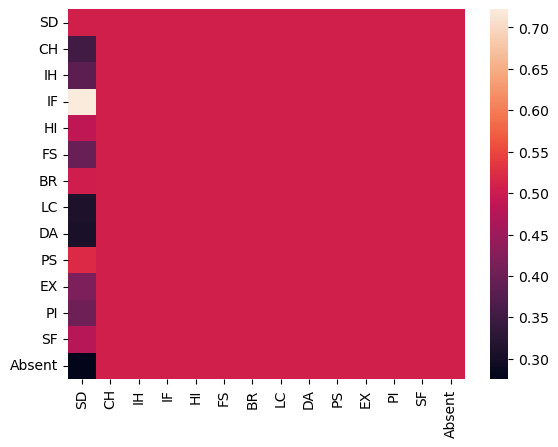

In [142]:
import seaborn as sns
%matplotlib inline
a2D = np.array([[0.506128995,],
                [0.353945685],
                [0.382442747],
                [0.721805804],
                [0.485188474],
                [0.395739044],
                [0.504960344],
                [0.310310221],
                [0.30565197],
                [0.520629931],
                [0.417190029],
                [0.400759797],
                [0.477041211],
                [0.275516699]
               ])
df = pd.DataFrame(a2D)
df = df.T


df.columns = ["SD", "CH", "IH", "IF", "HI", "FS", "BR", "LC", "DA","PS" ,"EX", "PI", "SF", "Absent"]
df = df.T
df.columns = ["SD", "CH", "IH", "IF", "HI", "FS", "BR", "LC", "DA","PS" ,"EX", "PI", "SF", "Absent"]
img = sns.heatmap(df)


In [146]:
fig = img.get_figure()
fig.savefig("out.png") 